In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
# ensure the dataset in a subfolder called data as below
data_file = "data/Epileptic Seizure Recognition.csv"

In [49]:
df = pd.read_csv(data_file)

In [50]:
df.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [51]:
# see which columns have NA values
columns_with_na = df.columns[df.isna().any(axis=0)].tolist()
print(f'These columns have NA values: {columns_with_na}')

These columns have NA values: []


In [52]:
df.shape

(11500, 180)

In [53]:
df.y.value_counts()

y
4    2300
1    2300
5    2300
2    2300
3    2300
Name: count, dtype: int64

In [54]:
# remove unusued column
df.drop('Unnamed', axis=1, inplace=True)

In [55]:
# classify having epileptic seizure or non-seisure
class_relabeling = {1:1, 2:0, 3:0, 4:0, 5:0}
df.replace({'y': class_relabeling}, inplace=True)

In [56]:
counts = df['y'].value_counts()
print(f"Number of records epileptic {counts[1]} vs non-epileptic {counts[0]}")

Number of records epileptic 2300 vs non-epileptic 9200


In [57]:
# describe non-epileptic data
df[df['y'] == 0].describe().T

,count,mean,std,min,25%,50%,75%,max
X1,9200.0,-8.992609,70.455286,-566.0,-44.0,-7.0,26.0,1726.0
X2,9200.0,-8.877174,70.560110,-609.0,-44.0,-7.0,27.0,1713.0
X3,9200.0,-8.910435,70.372582,-594.0,-45.0,-7.0,28.0,1697.0
X4,9200.0,-8.969783,70.030409,-549.0,-45.0,-8.0,27.0,1612.0
X5,9200.0,-9.085326,69.377958,-603.0,-45.0,-8.0,27.0,1437.0
...,...,...,...,...,...,...,...,...
X175,9200.0,-9.848587,69.550894,-570.0,-45.0,-9.0,27.0,1958.0
X176,9200.0,-9.620435,70.353607,-594.0,-46.0,-8.0,27.0,2047.0
X177,9200.0,-9.395435,70.934300,-563.0,-45.0,-9.0,27.0,2047.0
X178,9200.0,-9.240435,71.185850,-559.0,-45.0,-8.0,27.0,1915.0


In [58]:
# describe epileptic data
df[df['y'] == 1].describe().T

,count,mean,std,min,25%,50%,75%,max
X1,2300.0,-21.936522,342.361939,-1839.0,-193.25,-16.0,159.00,1314.0
X2,2300.0,-19.049130,343.398782,-1838.0,-191.25,-18.0,168.25,1356.0
X3,2300.0,-15.293913,337.489643,-1835.0,-187.00,-12.5,169.25,1274.0
X4,2300.0,-9.836087,332.354833,-1845.0,-184.00,-6.0,166.25,1226.0
X5,2300.0,-3.707391,332.211163,-1791.0,-174.25,-12.0,170.00,1518.0
...,...,...,...,...,...,...,...,...
X175,2300.0,-25.830870,339.650467,-1863.0,-195.00,-14.5,153.25,1205.0
X176,2300.0,-25.043913,335.747017,-1781.0,-192.00,-18.0,150.00,1371.0
X177,2300.0,-24.548261,335.244512,-1727.0,-190.25,-21.5,151.25,1445.0
X178,2300.0,-24.016522,339.819309,-1829.0,-189.00,-23.0,157.25,1380.0


In [31]:
# The neadapted from kaggle discussions of this dataset
# data is in 1s per row format
# first unpivot into single time series, preserve target y, then take the original index, which is the
# "sample index" of each sample
data_unpivoted = (df
                  .melt(id_vars=['y'], var_name='time_label', value_name='eeg', ignore_index=False)
                  .reset_index()
                  .rename(columns={'index': 'sample_index'})
                  )

# the time index is the index over the 1s time period in each original row in data
data_unpivoted['time_index'] = (data_unpivoted['time_label']
                                .str.extract(r'(\d+)', expand=False)
                                .astype(int)
                                )

# sort each window according to the sample and time and re-order columns
data_unpivoted = (data_unpivoted
                  .sort_values(by=['sample_index', 'time_index'])
                  .reindex(['sample_index', 'time_index', 'eeg', 'y'], axis=1)
                 )

In [32]:
data_unpivoted

,sample_index,time_index,eeg,y
0,0,1,135,0
11500,0,2,190,0
23000,0,3,229,0
34500,0,4,223,0
46000,0,5,192,0
...,...,...,...,...
2000999,11499,174,5,0
2012499,11499,175,4,0
2023999,11499,176,-2,0
2035499,11499,177,2,0


In [33]:
data_unpivoted[data_unpivoted['sample_index'] == 0]

,sample_index,time_index,eeg,y
0,0,1,135,0
11500,0,2,190,0
23000,0,3,229,0
34500,0,4,223,0
46000,0,5,192,0
...,...,...,...,...
1989500,0,174,-103,0
2001000,0,175,-127,0
2012500,0,176,-116,0
2024000,0,177,-83,0


In [34]:
n = 5

index_n_epileptic = data_unpivoted[data_unpivoted['y'] == 1]["sample_index"].unique()[:n]
index_n_nonepileptic = data_unpivoted[data_unpivoted['y'] == 0]["sample_index"].unique()[:n]

samples_to_show = np.concatenate((index_n_epileptic, index_n_nonepileptic))

C:\Users\samga\anaconda3\envs\tf_cuda\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


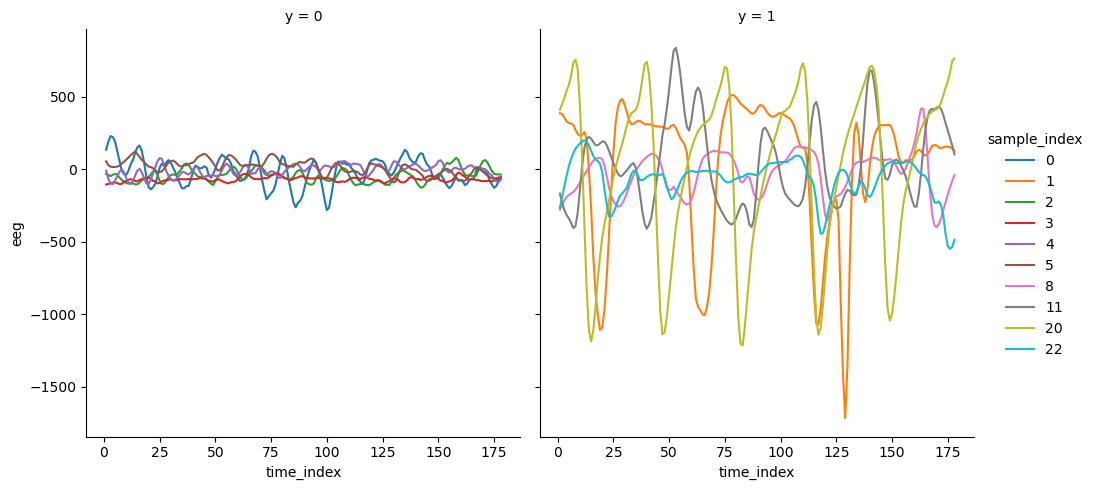

In [35]:
g = sns.relplot(
    data=data_unpivoted[data_unpivoted["sample_index"].isin(samples_to_show)],
    kind='line',
    x='time_index',
    y='eeg',
    col='y',
    hue='sample_index',
    legend='full',
    palette=sns.color_palette()
)

plt.show()

C:\Users\samga\anaconda3\envs\tf_cuda\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


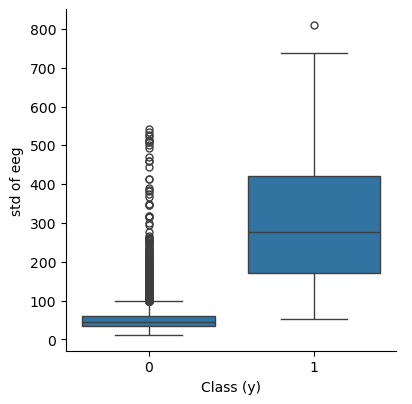

In [46]:

g = sns.catplot(
    data=data_unpivoted.groupby(["sample_index", "y"]).std().reset_index(),
    kind='box',
    x='y',
    y='eeg',
)



g.fig.set_size_inches(4, 4)
g.set_titles("Standard Deviation of EEG by Class")
g.set_axis_labels("Class (y)", "Standard Deviation of EEG")
g.set_ylabels("std of eeg")


#medians = data_unpivoted.groupby(["y"])["eeg"].median().values
#for tick, label in zip(range(len(medians)), g.ax.get_xticklabels()):
#    g.ax.text(tick, medians[tick], f"{medians[tick]:.2f}", 
#              horizontalalignment='center', color='black', weight='semibold')

C:\Users\samga\anaconda3\envs\tf_cuda\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


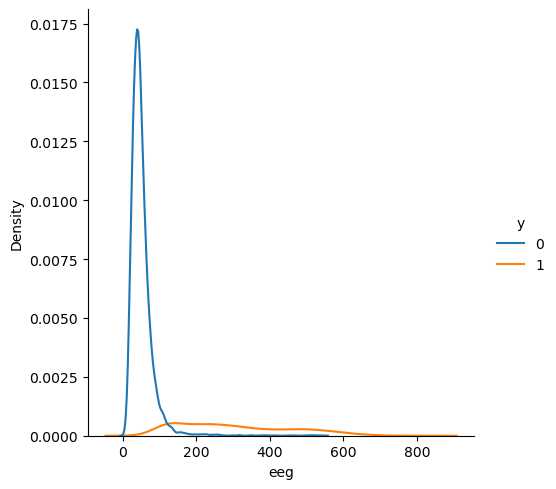

In [28]:
sns.displot(
    data=data_unpivoted.groupby(["sample_index", "y"]).std().reset_index(),
    kind='kde',
    x='eeg',
    hue='y'
)